In [1]:
from dotenv import load_dotenv
import os

load_dotenv('../.env_api')

os.environ["HTTP_PROXY"] = "http://localhost:9090"
os.environ["HTTPS_PROXY"] = "http://localhost:9090"
# os.environ["NO_PROXY"] = os.getenv("NO_PROXY", "localhost,127.0.0.1,qdrant,::1")
os.environ["REQUESTS_CA_BUNDLE"] = "/Users/tomek/Library/Application Support/com.proxyman.NSProxy-setapp/app-data/proxyman-ca.pem"
os.environ["SSL_CERT_FILE"] = "/Users/tomek/Library/Application Support/com.proxyman.NSProxy-setapp/app-data/proxyman-ca.pem"

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Literal, Dict, Any, Annotated, List, Optional
from operator import add
import random
import ast
import inspect
from langgraph.prebuilt import ToolNode
from jinja2 import Template
import instructor
from openai import OpenAI
from langchain_core.messages import AIMessage, ToolMessage
import json

from qdrant_client import QdrantClient
# from src.api.core.config import config
from langsmith import traceable, get_current_run_tree
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery
import openai
import logging

from rich.pretty import pprint

logger_id = 0

In [2]:
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]

for logger in loggers:
    logger.handlers.clear()
    logger.propagate = False
    logger.disabled = True

logger_id += 1
logger = logging.getLogger('Notebook ' + str(logger_id))
logger.propagate = True
logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
formatter = logging.Formatter(f"\033[94m%(asctime)s %(levelname)s %(name)s %(message)s\033[0m")
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False
logger.info("Retrieval logger initialized")

2025-07-25 11:48:38,212 INFO Notebook 1 Retrieval logger initialized


# Langgraph Single Turn Assistant

### Define a retrieval tool

In [4]:
qdrant_client = QdrantClient(
    url=f'http://localhost.proxyman.io:6333'
)

@traceable(
    name="embed_query_text",
    run_type="embedding",
    metadata={"ls_provider": 'openai', "ls_model_name": 'text-embedding-3-small'}
)
def get_embedding_openai(text, model='text-embedding-3-small'):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    current_run = get_current_run_tree()
    if current_run:
        current_run.metadata['usage_metadata'] = {
            'input_tokens': response.usage.prompt_tokens,
            'total_tokens': response.usage.total_tokens,
        }
    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever",
)
def retrieve_context(query, embedding_type = 'text', fusion = True, top_k=5):
    embedding_function = get_embedding_openai 
    if embedding_type == 'image':
        embedding_function = get_embedding_openclip
    query_embedding = embedding_function(query)
    collection_name = 'Amazon-items-collection-01-hybrid'
    if fusion:
        logger.info("Fusion enabled. Retrieving for query: {} top {} results from {} collection".format(query, top_k, collection_name))
        results = qdrant_client.query_points(
            collection_name=collection_name,
            prefetch=[
                Prefetch(
                    query=query_embedding,
                    limit=20,
                ),
                Prefetch(
                    filter=Filter(
                        must=[
                            FieldCondition(
                                key="text",
                                match=MatchText(
                                    text=query,
                                )
                            )
                        ]
                    ),
                    limit=20
                )
            ],
            query=FusionQuery(fusion="rrf"),
            limit=top_k,
        )
    else:
        logger.info("Fusion disabled. Retrieving top {} results from {} collection".format(top_k, collection_name))
        results = qdrant_client.query_points(
            collection_name=collection_name,
            query=query_embedding,
            limit=top_k,
        )
    logger.info(f"Retrieved {len(results.points)} results")
    current_run = get_current_run_tree()
    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    for result in results.points:
        retrieved_context_ids.append(result.id)
        retrieved_context.append(result.payload['text'])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "similarity_scores": similarity_scores,
    }

@traceable(
    name="format_retrieved_context",
    run_type="prompt",
)
def process_context(context):
    formatted_context = ""
    for index, chunk in zip(context['retrieved_context_ids'], context['retrieved_context']):
        formatted_context += f"- {index}: {chunk} \n"

    return formatted_context

def get_formatted_context(query: str, top_k: int = 5) -> str:
    """Get the top k context, each representing an inventory item for a given query.
    
    Args:
        query: The query to get the top k context for
        top_k: The number of context chunks to retrieve, works best with 5 or more
    
    Returns:
        A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.
    """

    context = retrieve_context(query, top_k=top_k)
    formatted_context = process_context(context)
    return formatted_context

In [5]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class RAGUsedContext(BaseModel):
    id: int
    description: str

class AgentResponse(BaseModel): # structured output for pydantic
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context: List[RAGUsedContext]


class State(BaseModel):
    messages: Annotated[List[Any], add] = [] # reducer (it will add messages to the list)
    iteration: int = Field(default=0)
    answer: str = ""
    final_answer: bool = Field(default=False)
    available_tools: List[Dict[str, Any]] = []
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context: Annotated[List[RAGUsedContext], add] = []

In [6]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": 'openai', "ls_model_name": 'gpt-4.1-mini'}
)
def agent_node(state: State) -> dict:
   prompt_template =  """    
You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specificly provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
- You need to answer the question based on the retrieved context using the available tools only.
- Never use word context and refer to it as the available products.
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
- As a final output you need to provide:

* The answer to the question based on the retrieved context.
* The list of the indexes from the chunks returned from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
* Short description of the item based on the retrieved context.

- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.
- The short description should have the name of the item.
- If the user's request requires using a tool, set tool_calls with the appropriate function name and arguments.
- If you have all the information needed to provide a complete answer, set final_answer to True.
""" 

   template = Template(prompt_template)

   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []
   for message in messages:
      conversation.append(lc_messages_to_regular_messages(message))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
      model="gpt-4.1-mini",
      response_model=AgentResponse,
      messages=[{"role": "system", "content": prompt}, *conversation],
      temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
      )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "retrieved_context": response.retrieved_context,
   }

In [24]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""

    if state.final_answer:
        return 'end'
    elif state.iteration > 3:
        return 'end'
    elif len(state.tool_calls) > 0:
        return 'tools'
    else:
        return 'end'

In [20]:
workflow = StateGraph(State)

tools = [get_formatted_context]

tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node('agent_node', agent_node)
workflow.add_node('tool_node', tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    'agent_node',
    tool_router,
    {
        'tools': 'tool_node',
        'end': END
    }
)
workflow.add_edge('tool_node', 'agent_node')

graph = workflow.compile()

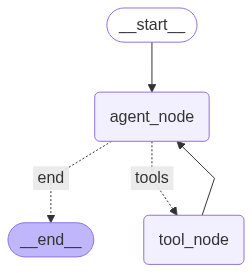

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "available_tools": tool_descriptions
}

result = graph.invoke(initial_state)


2025-07-25 12:38:20,127 INFO Notebook 1 Fusion enabled. Retrieving for query: laptop bag top 3 results from Amazon-items-collection-01-hybrid collection
2025-07-25 12:38:20,345 INFO Notebook 1 Fusion enabled. Retrieving for query: earphones top 3 results from Amazon-items-collection-01-hybrid collection
2025-07-25 12:38:20,420 INFO Notebook 1 Retrieved 3 results
2025-07-25 12:38:20,423 INFO Notebook 1 Retrieved 3 results
2025-07-25 12:38:21,191 INFO Notebook 1 Fusion enabled. Retrieving for query: kids toys top 3 results from Amazon-items-collection-01-hybrid collection
2025-07-25 12:38:21,205 INFO Notebook 1 Retrieved 3 results


In [15]:


for data in result['messages']:
    pprint(data)

{'role': 'user', 'content': 'Do you have any earphones or tv remotes?'}

AIMessage(
│   content='I will check for earphones and TV remotes in the available products.',
│   additional_kwargs={},
│   response_metadata={},
│   tool_calls=[
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   'id': 'call_0',
│   │   │   'type': 'tool_call'
│   │   },
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'args': {'query': 'TV remote', 'top_k': 5},
│   │   │   'id': 'call_1',
│   │   │   'type': 'tool_call'
│   │   }
│   ]
)

ToolMessage(
│   content="- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 24: Wireless Earbuds Bluetooth Headphones 130Hrs Playtime with 2500mAh Wireless Charging Case LED Diaplay Hi-Fi Waterproof Over Ear Earphones for Sports Running Workout Gaming Wireless Charging Case with LED Display: 2500mAh charging case supports 16 times fully charging for wireless earbuds and let you enjoy more than 130 hours music time. Each earbud can get 8hrs playback on a single charge. Charging c

ToolMessage(
│   content='- 41: (Pack of 2) Replaced Remote Control Only for Roku TV,Compatible for TCL Roku/Hisense Roku/Insignia Roku/Element Roku/Westinghouse Roku/Hitachi Roku TV【Not for Roku Stick and Box】 【Quality Material】All the buttons function. The remote is light weight. The battery cover stays on well. It works just as well as the remote that came with your TV. 【HIGH QUALITY】Our remote has been upgraded to give you a greater transmitting distance (over25 ft) and has a quick response time of 0.3 seconds,and the buttons have been tested to support over 120000 click. 【Important Notes】The remote ONLY suitable for all Roku TVs. It is NOT compatible with any for Roku Stick,NOT for Roku Streaming Stick,NOT for Roku Box 1/2/3/4(HD/LT/XS/XD),NOT for Roku Ultra,NOT for Roku Express,NOT for Roku Premiere ，NOT for Roku Player 【With 4 Shortcuts】Universal TV Remote features shortcut buttons for Netflix, Disney+, Prime video,and Hulu for extra convenience.Press the Disney button on the remote and it takes you to your Disney plus account, press the Netflix button and it takes you to your Netflix account! 【No Pairing Required】Pack of 2 universial replacement remote control fit for Roku TVs, no programming and no pairing needed, just put the 2*AAA batteries in and it worked immediately. (Note: batteries and manual are not included) \n- 32: Bose Solo 5 TV Sound System with Universal Remote Control & Amazon Basics Digital Optical Audio Toslink Cable - 3.28 Feet (1 Meter)  \n- 12: YOTON 17.5" Portable DVD Player with 15.5" HD Swivel Screen for Car and Kids, 4-6 Hours Working Time with Built-in Battery, Dual Stereo Speakers, USB/SD/AV/Audio/Gamepad Support [Not Support Blu-Ray] 💖【Immersive Movie Experience】 The YOTON 15.5-inch jumbo screen portable DVD player with dual speakers and a high resolution of 1280x800 provides you with a great viewing experience with amazing images and stereo surround sound. This player only supports video files with 720x480 resolution and image files with 2650x1440 resolution, not 1080P, 4K, or Blu-ray discs! 💙 【Large capacity built-in battery】 The YD155 portable DVD player can work for about 4-6 hours when fully charged, and can watch 2-3 movies completely. Equipped with a certified high-quality car charger, you can use it on the go with confidence. 💚【Sync Screen to TV】 Want a bigger screen? The YOTON YD155 portable DVD player has a large 15.5-inch screen and can be connected to your TV, projector, or other portable DVD players to easily create a private theater for your and your family\'s pleasure. 💛【Flexible Rotating Screen】The HD screen of the DVD player can rotate 270°, you can freely switch the angle as you need to get the perfect viewing angle. 💜【Last Memory Function】YOTON portable DVD player has an intelligent memory function, when you turn on the DVD player, the DVD player will automatically jump to the last viewing position to continue watching movies. 🎁 【Accessory】Portable DVD player YD155 x1, Remote control (battery not included) x1, AC Power Adaptor x1, Car charger x1, 3-in-1 AV cable x1. 🔧【WARRANTY】12-MONTH Warranty, 24-HOUR Friendly customer support. Feel free to contact us with any questions you may have. ❗【Note】 Only supports 720x480 resolution video files and 2650x1440 resolution image files, and does not support 1080P, 4K, or Blu-ray discs. \n- 4: ELIVED Ceiling TV Mount Fits Most 26-65 Inch LED, LCD OLED Flat Screen TVs, Full Motion Height Adjustable TV Mount Bracket, Swivel and Tilt TV Bracket, Max VESA 400x400mm, Holds up to 99 lbs. Wide Compatibility: This ceiling TV mount fits most 26-65 inch LCD, LED, OLED flat screen TVs with VESA mounting hole patterns 100 x 100 mm (4" x 4") to 400 x 400 mm (16" x 16"), holds up to 99 lbs /45 kg. Please check the TV weight, size, VESA range, and input access before purchase. 6 Height Adjustment: The ceiling mount TV bracket has 6 positions for height adjustment, suspends TV 20.3” from the ceiling and can extend up to 30.2” to provide better viewing 

AIMessage(
│   content='Yes, we have earphones and TV remotes available in stock. Here are some options:\n\nEarphones:\n1. IKG Wireless Earbuds\n   - Bluetooth 5.3 with automatic one-step connection\n   - 30 hours playtime with transparent charging case\n   - IPX7 waterproof and touch operation\n   - Deep bass, CVC8.0 noise reduction, and in-ear recognition\n\n2. Wireless Earbuds Bluetooth 5.3 Headphones\n   - Deep bass and premium sound with mic\n   - 5 hours playback per earbud, 22+ hours with charging case\n   - Comfortable and secure fit with touch control\n\n3. Wireless Earbuds Bluetooth Headphones\n   - 130 hours playtime with 2500mAh wireless charging case\n   - Hi-Fi stereo bass and crystal-clear calling\n   - IPX7 waterproof with ergonomic lightweight earhooks\n\n4. EYIW 2 Pack Headphone Adapter for iPhone\n   - Apple MFi Certified Lightning to 3.5mm splitter\n   - Supports 48KHz and 24-bit audio output\n   - Plug and play for all lightning connector devices\n\n5. RP-TCM125-A in-Ear Buds with Mic & Remote for Smartphone\n   - Ergonomic design with S/M/L sized soft ear pieces\n   - Cord length 1.1m, frequency response 10Hz - 24kHz\n\nTV Remotes:\n1. Pack of 2 Replacement Remote Control for Roku TV\n   - Compatible with TCL Roku/Hisense Roku/Insignia Roku/Element Roku/Westinghouse Roku/Hitachi Roku TVs\n   - No programming or pairing needed\n   - Shortcut buttons for Netflix, Disney+, Prime Video, Hulu\n\n2. Bose Solo 5 TV Sound System with Universal Remote Control\n   - Comes with Amazon Basics Digital Optical Audio Toslink Cable\n\nIf you need more details or want to know about other products, please let me know!',
│   additional_kwargs={},
│   response_metadata={},
│   tool_calls=[
│   │   {
│   │   │   'name': 'functions.get_formatted_context',
│   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   'id': 'call_0',
│   │   │   'type': 'tool_call'
│   │   },
│   │   {
│   │   │   'name': 'functions.get_formatted_context',
│   │   │   'args': {'query': 'TV remote', 'top_k': 5},
│   │   │   'id': 'call_1',
│   │   │   'type': 'tool_call'
│   │   }
│   ]
)

In [23]:
pprint(result)

{
│   'messages': [
│   │   {
│   │   │   'role': 'user',
│   │   │   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'
│   │   },
│   │   AIMessage(
│   │   │   content='I will look for earphones, a laptop bag, and something cool for kids in the available products for you.',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'earphones', 'top_k': 3},
│   │   │   │   │   'id': 'call_0',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 3},
│   │   │   │   │   'id': 'call_1',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'kids toys', 'top_k': 3},
│   │   │   │   │   'id': 'call_2',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ]
│   │   ),
│   │   ToolMessage(
│   │   │   content='- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment wi

# Tools copy pasted from Aurimas Github

In [26]:
def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""}
    }
    
    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result
        
    func = tree.body[0]
    result["name"] = func.name
    
    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = docstring.find('\n\n') if '\n\n' in docstring else docstring.find('\nArgs:')
        desc_end = desc_end if desc_end > 0 else docstring.find('\nParameters:')
        result["description"] = docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        
        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)
        
        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = docstring.split("Returns:")[1].strip().split('\n')[0]
    
    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)
    
    for i, arg in enumerate(args.args):
        if arg.arg == 'self':
            continue
            
        param_info = {
            "type": get_type_from_annotation(arg.annotation) if arg.annotation else "string",
            "description": param_descs.get(arg.arg, "")
        }
        
        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)
        
        result["parameters"]["properties"][arg.arg] = param_info
    
    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)
    
    return result

def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"
    
    type_map = {
        'str': 'string',
        'int': 'integer', 
        'float': 'number',
        'bool': 'boolean',
        'list': 'array',
        'dict': 'object',
        'List': 'array',
        'Dict': 'object'
    }
    
    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(annotation.value, ast.Name):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())
    
    return "string"

def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [11]:
def get_tool_descriptions_from_node(tool_node):
    """Extract tool descriptions from the ToolNode object."""
    descriptions = []
    
    if hasattr(tool_node, 'tools_by_name'):
        tools_by_name = tool_node.tools_by_name
        
        for tool_name, tool in tools_by_name.items():
            function_string = inspect.getsource(globals()[tool_name])
            # function_string = inspect.getsource(getattr(tool_name))
            result = parse_function_definition(function_string)

            if result:
                descriptions.append(result)
    
    return descriptions if descriptions else "Could not extract tool descriptions"

In [ ]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}